In [33]:
''' Import required libraries.
'''

import csv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

You are given a data-set with 1000 data points each in $\mathbb{R}^2$ (cm dataset 2.csv).

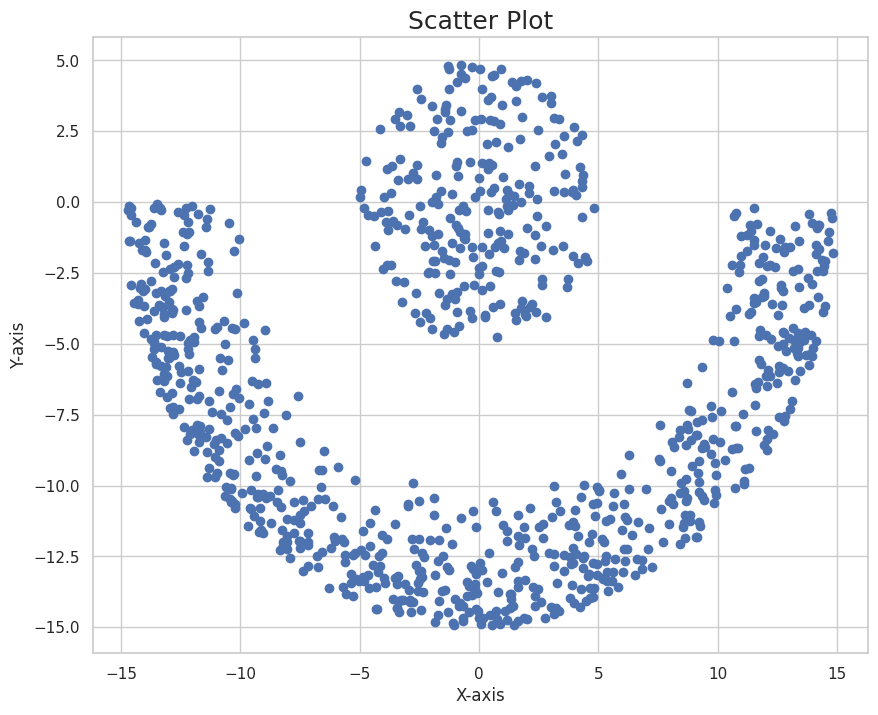

In [34]:
# Specify the path to your CSV file
csv_file_path = 'dataset.csv'

# Open the CSV file using the built-in 'open' function
with open(csv_file_path, 'r', newline='') as file:
    # Create a CSV reader object
    csv_reader = csv.reader(file)

    # Convert the CSV data to a list of lists
    data_list = [row for row in csv_reader]

# Convert the list of lists to a NumPy array
dataset = np.array(data_list).astype(float)

# Plot the scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(dataset[:, 0], dataset[:, 1])
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot', fontsize=18)
plt.savefig('images/problem-2/scatter-plot.pdf')
plt.show()


1. Write a piece of code to run the algorithm studied in class for the $K -$means problem with $k = 2$. Try 5 different random initialization and plot the error function w.r.t iterations in each case. In each case, plot the clusters obtained in different colors.

In [35]:
class KMeans:
    def __init__(self, k=3, max_iters=500, tol=1e-5, k_means_plusplus=False):
        self.k = k
        self.max_iters = max_iters
        self.tol = tol
        self.k_means_plusplus = k_means_plusplus
        self.centroids = None
        self.labels = None
        self.n_samples = None
        self.n_features = None
        self.objective_value = None

    def fit(self, X):
        self.n_samples, self.n_features = X.shape

        # Initialization of centroids
        if self.k_means_plusplus:
            self.centroids = self.k_means_plusplus_init(X)
        else:
            self.centroids = X[np.random.choice(self.n_samples, self.k, replace=False)]

        for _ in range(self.max_iters):
            # Assign each data point to the closest centroid
            distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
            self.labels = np.argmin(distances, axis=1)

            # Update centroids based on the mean of points in each cluster
            new_centroids = np.array([X[self.labels == j].mean(axis=0) for j in range(self.k)])

            # Check for convergence
            if np.linalg.norm(new_centroids - self.centroids) < self.tol:
                break

            self.centroids = new_centroids

        self.labels = np.argmin(distances, axis=1)  # Assign cluster labels
        self.objective_value = self.calculate_objective_value(X)  # Calculate the objective value
        return self.labels, self.centroids  # Return the cluster labels for each data point

    def k_means_plusplus_init(self, X):
        # Initialize the centroids
        self.centroids = np.zeros((self.k, self.n_features), dtype=X.dtype)

        # Randomly choose the first centroid
        self.centroids[0] = X[np.random.choice(self.n_samples)]

        # Choose the remaining centroids using the k-means++ initialization
        for i in range(1, self.k):
            min_distances = np.full((self.n_samples,), np.inf)

            for j in range(i):
                distances = np.linalg.norm(X - self.centroids[j], axis=1)
                min_distances = np.minimum(min_distances, distances)

            # Handle zero min_distances
            if np.all(min_distances == 0):
                # If all distances are zero, select a random point as the next centroid
                self.centroids[i] = X[np.random.choice(self.n_samples)]
            else:
                # Handle NaN values in min_distances
                min_distances[np.isnan(min_distances)] = 0

                # Check for NaN in probabilities
                if np.any(np.isnan(min_distances)) or np.any(min_distances == 0):
                    # If there are NaN values or all distances are zero, select a random point
                    self.centroids[i] = X[np.random.choice(self.n_samples)]
                else:
                    # Calculate probabilities and choose the next centroid
                    probabilities = min_distances**2 / np.sum(min_distances**2)
                    probabilities[np.isnan(probabilities)] = 0  # Handle NaN in probabilities
                    self.centroids[i] = X[np.random.choice(self.n_samples, p=probabilities)]

        return self.centroids

    def plot_clusters(self, X):
        plt.scatter(X[:, 0], X[:, 1], c=self.labels, cmap='viridis', alpha=0.5)
        plt.scatter(self.centroids[:, 0], self.centroids[:, 1], marker='X', s=200, c='red', label='Centroids')
        h = 0.02
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        Z = self.predict(np.c_[xx.ravel(), yy.ravel()])  # Use predict method to get cluster labels for mesh grid
        Z = Z.reshape(xx.shape)
        plt.contour(xx, yy, Z, colors='k', linewidths=2, alpha=1)
        if self.k_means_plusplus == False:
            plt.title(f'K-means Clustering (K = {self.k})', fontsize=18)
        else:
            plt.title(f'K-means Clustering++ (K = {self.k})', fontsize=18)
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.legend()
        if self.k_means_plusplus == False:
            plt.savefig(f'images/problem-2/K-means_Clustering_({self.k}).pdf')
        else:
            plt.savefig(f'images/problem-2/K-means_Clustering_plusplus_({self.k}).pdf')
        plt.show()

    def predict(self, X):
        distances = np.linalg.norm(X - self.centroids[:, np.newaxis], axis=2)
        return np.argmin(distances, axis=0)

    def calculate_objective_value(self, X):
        distances = np.linalg.norm(X - self.centroids[self.labels], axis=1)
        return np.sum(distances**2)

    def calculate_aic(self, X):
        k = self.k
        n = X.shape[0]
        obj_value = self.objective_value
        aic = 2 * k + n * np.log(obj_value / n)
        return aic

    def calculate_bic(self, X):
        k = self.k
        n = X.shape[0]
        obj_value = self.objective_value
        bic = k * np.log(n) + n * np.log(obj_value / n)
        return bic

    def plot_tolerance_vs_epoch(self, X, seed):
        """
        Plot tolerance vs. epoch for a single K-means initialization.

        Parameters:
        - X: Input data.
        """
        self.centroids = None
        self.labels = None
        self.objective_value = None

        # Initialization of centroids
        if self.k_means_plusplus:
            self.centroids = self.k_means_plusplus_init(X)
        else:
            self.centroids = X[np.random.choice(self.n_samples, self.k, replace=False)]

        tolerance_values = []

        for epoch in range(self.max_iters):
            # Assign each data point to the closest centroid
            distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
            self.labels = np.argmin(distances, axis=1)

            # Update centroids based on the mean of points in each cluster
            new_centroids = np.array([X[self.labels == j].mean(axis=0) for j in range(self.k)])

            # Check for convergence
            tolerance = np.linalg.norm(new_centroids - self.centroids)
            tolerance_values.append(tolerance)
            if tolerance < self.tol:
                break

            self.centroids = new_centroids

        # Plotting tolerance vs. epoch
        plt.plot(range(1, len(tolerance_values) + 1), tolerance_values)
        plt.xlabel('Epoch')
        plt.ylabel('Tolerance')
        if self.k_means_plusplus == True:
            plt.title(f'Tolerance vs. Epoch (++): seed:{seed}', fontsize = 18)
            plt.savefig(f'images/problem-2/Tolerance vs. Epoch (++): seed:{seed}.pdf')
        else:
            plt.title(f'Tolerance vs. Epoch (random): seed:{seed}', fontsize = 18)
            plt.savefig(f'images/problem-2/Tolerance vs. Epoch (random): seed:{seed}.pdf')

        plt.show()

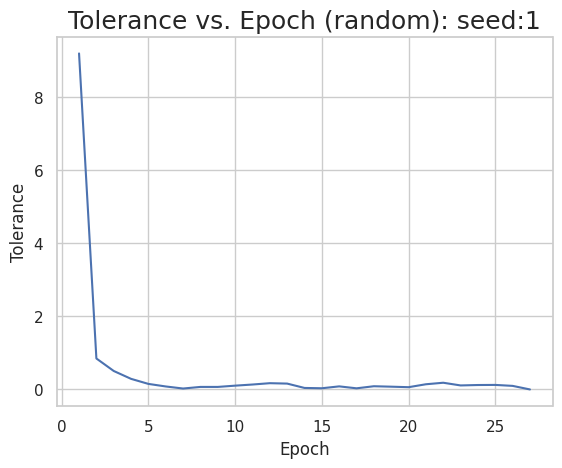

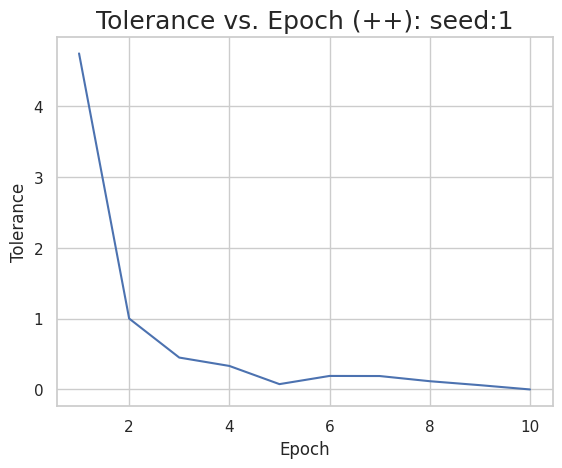

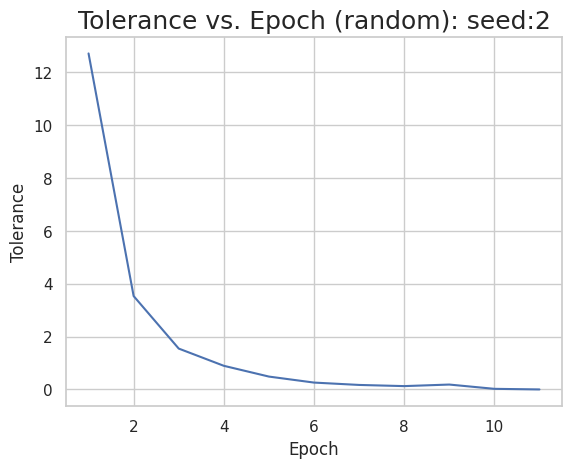

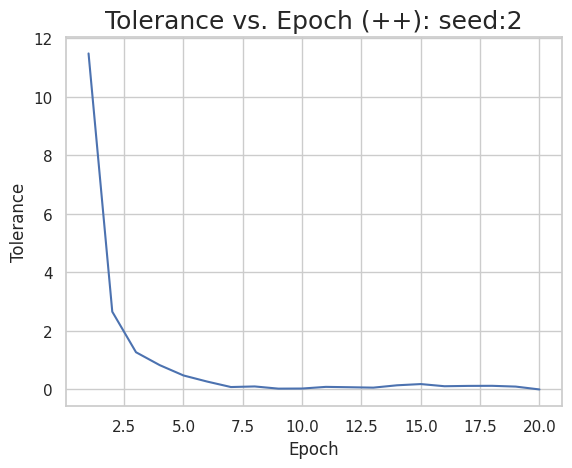

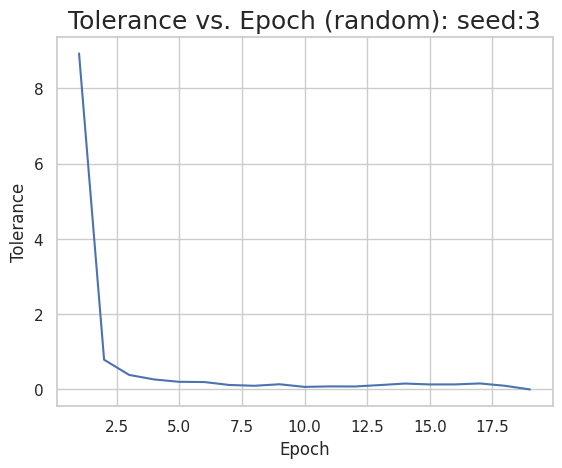

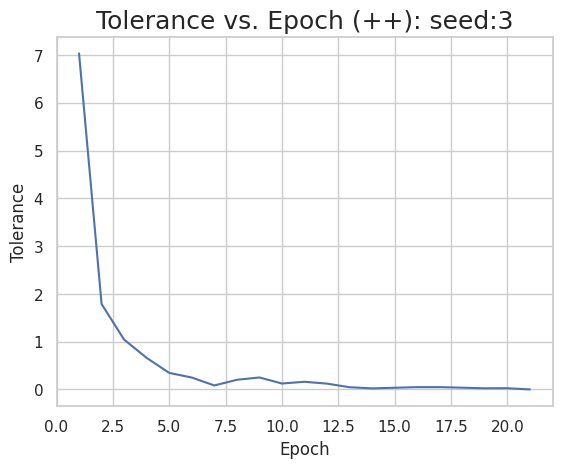

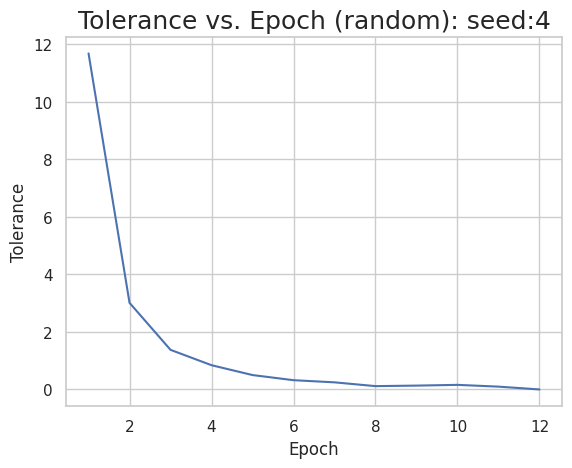

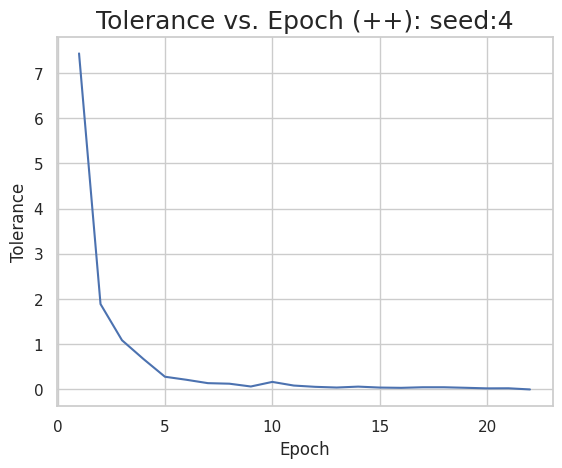

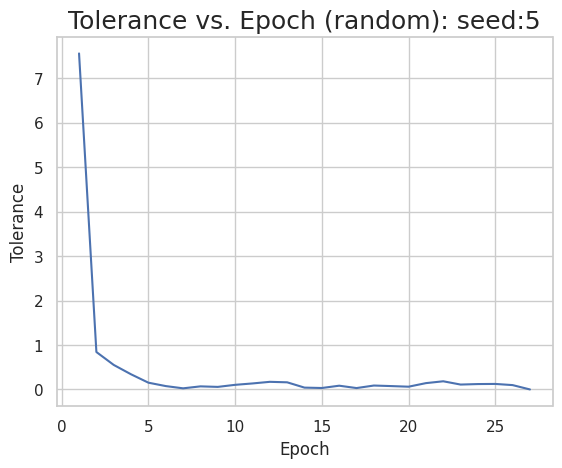

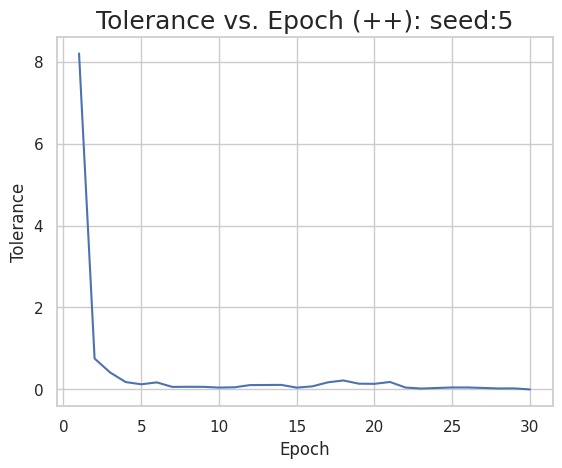

In [36]:
'''Tolerance'''
seeds = [1, 2, 3, 4, 5]

# Set the number of clusters (k)
num_clusters = 2

for i in range(len(seeds)):
    np.random.seed(seeds[i])
    # Create KMeans object with K-means++ initialization
    kmeans = KMeans(k=num_clusters, k_means_plusplus=False)
    kmeans_labels = kmeans.fit(dataset)
    kmeans.plot_tolerance_vs_epoch(dataset, seeds[i])

    # Create KMeans object with random initialization
    kmeans_plusplus = KMeans(k=num_clusters, k_means_plusplus=True)
    kmeans_plusplus_labels = kmeans_plusplus.fit(dataset)
    kmeans_plusplus.plot_tolerance_vs_epoch(dataset, seeds[i])

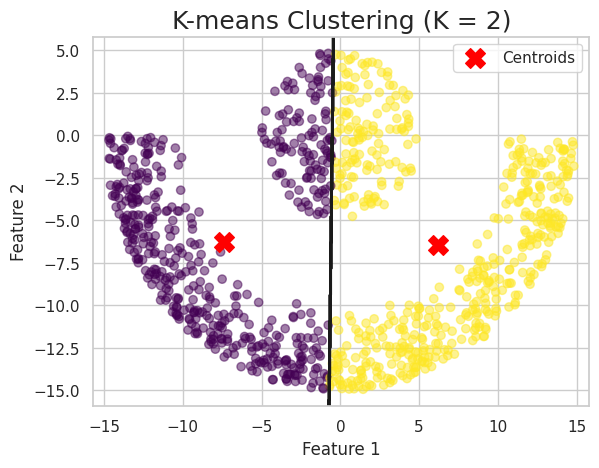

K-means - Objective value: 50730.14722491366
K-means - AIC: 3930.520353701603
K-means - BIC: 3940.3358642595676


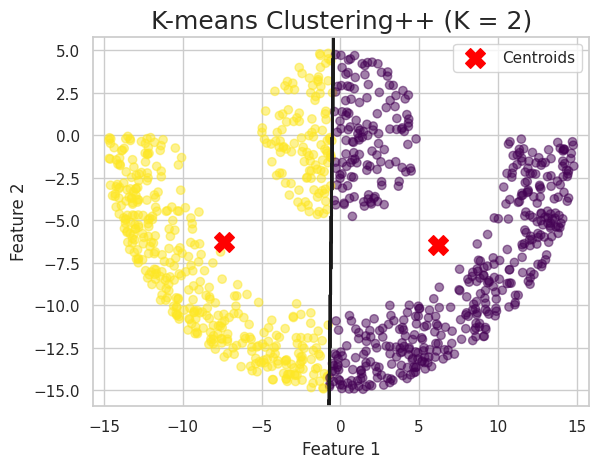

K-means++ - Objective value: 50730.14722491366
K-means++ - AIC: 3930.520353701603
K-means++ - BIC: 3940.3358642595676


In [37]:
seed = 87
np.random.seed(seed)

# Set the number of clusters (k)
num_clusters = 2

# Create KMeans object with K-means++ initialization
kmeans = KMeans(k=num_clusters, k_means_plusplus=False)
kmeans_labels = kmeans.fit(dataset)
kmeans.plot_clusters(dataset)

# Print objective value, AIC, and BIC for K-means
print(f"K-means - Objective value: {kmeans.objective_value}")
print(f"K-means - AIC: {kmeans.calculate_aic(dataset)}")
print(f"K-means - BIC: {kmeans.calculate_bic(dataset)}")

# Create KMeans object with random initialization
kmeans_plusplus = KMeans(k=num_clusters, k_means_plusplus=True)
kmeans_plusplus_labels = kmeans_plusplus.fit(dataset)
kmeans_plusplus.plot_clusters(dataset)

# Print objective value, AIC, and BIC for K-means++
print(f"K-means++ - Objective value: {kmeans_plusplus.objective_value}")
print(f"K-means++ - AIC: {kmeans_plusplus.calculate_aic(dataset)}")
print(f"K-means++ - BIC: {kmeans_plusplus.calculate_bic(dataset)}")


#################### Result for k=2 ####################


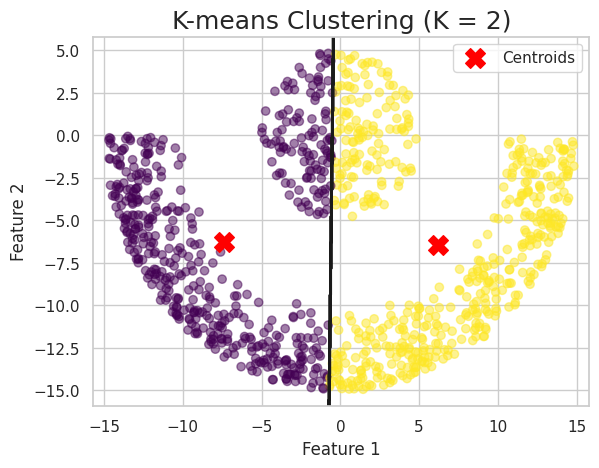

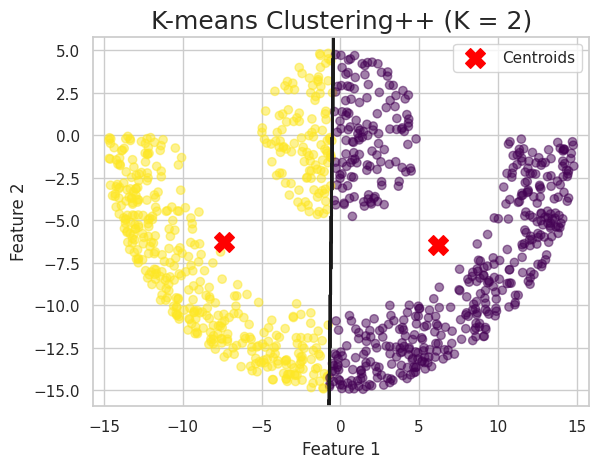

K-means++ - Objective value: 50730.14722491366
K-means++ - AIC: 3930.520353701603
K-means++ - BIC: 3940.3358642595676

#################### Ending for k=2 ####################

#################### Result for k=3 ####################


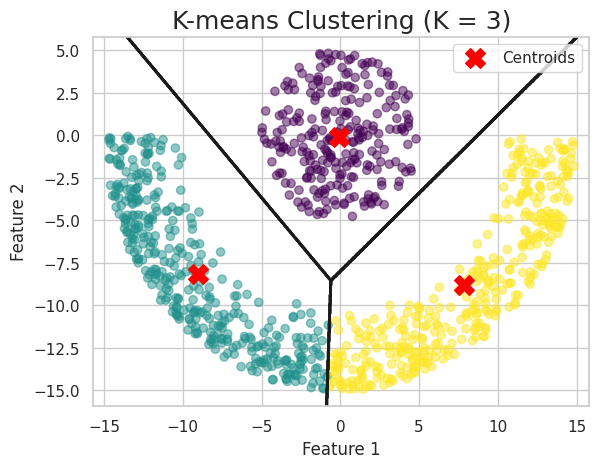

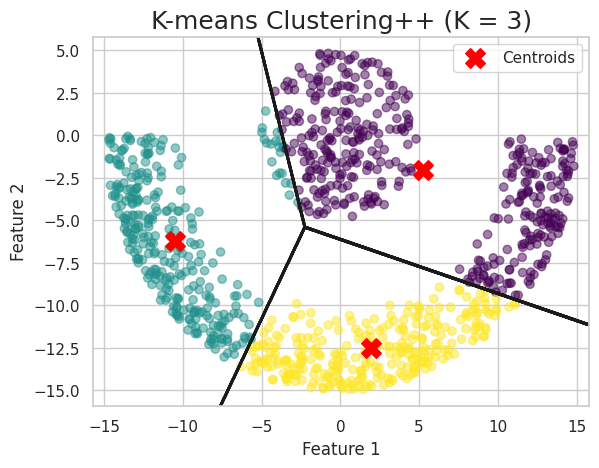

K-means++ - Objective value: 30493.904575326458
K-means++ - AIC: 3423.526813651399
K-means++ - BIC: 3438.2500794883454

#################### Ending for k=3 ####################

#################### Result for k=4 ####################


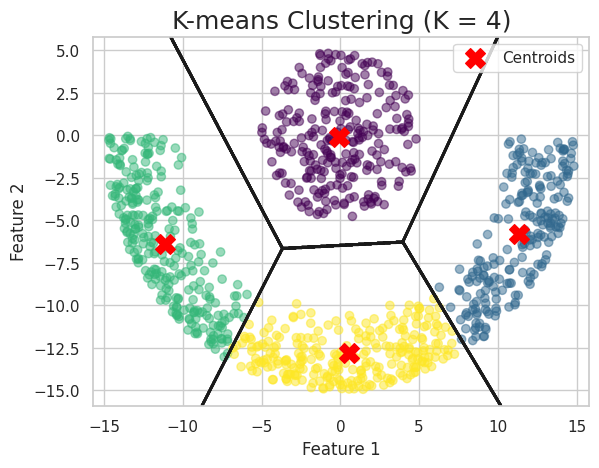

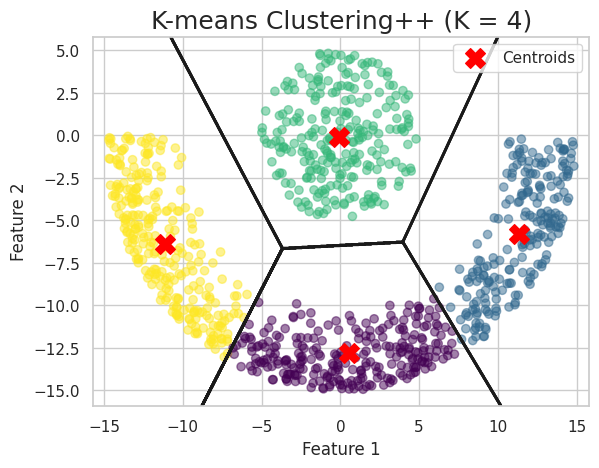

K-means++ - Objective value: 15155.129419863792
K-means++ - AIC: 2726.3390502201714
K-means++ - BIC: 2745.9700713361

#################### Ending for k=4 ####################

#################### Result for k=5 ####################


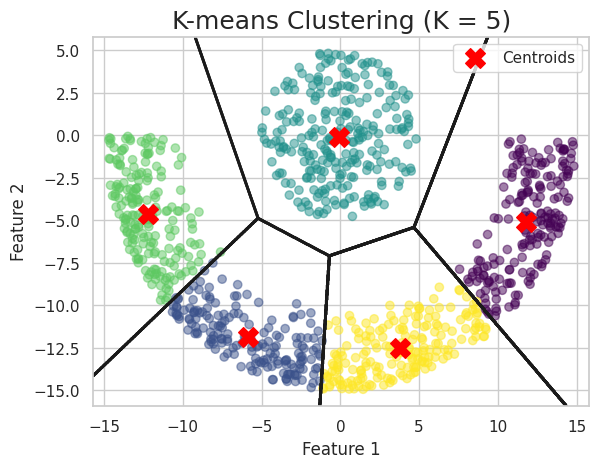

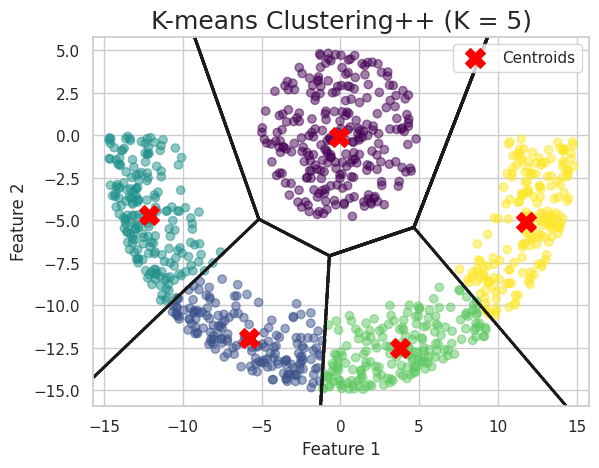

K-means++ - Objective value: 10594.005976398857
K-means++ - AIC: 2370.2883672527078
K-means++ - BIC: 2394.8271436476184

#################### Ending for k=5 ####################



In [38]:
seed = 87
np.random.seed(seed)

# Set the number of clusters (k)
num_clusters = np.array([2, 3, 4, 5])

# Lists to store values for plotting
k_values = []
objective_values_kmeans = []
aic_values_kmeans = []
bic_values_kmeans = []
objective_values_kmeans_plusplus = []
aic_values_kmeans_plusplus = []
bic_values_kmeans_plusplus = []

for k in num_clusters:
    # Append k value
    k_values.append(k)
    print(f'#################### Result for k={k} ####################')

    # Create KMeans object with random initialization
    kmeans = KMeans(k=k, k_means_plusplus=False)
    kmeans_labels = kmeans.fit(dataset)
    kmeans.plot_clusters(dataset)

    objective_values_kmeans.append(kmeans.objective_value)
    aic_values_kmeans.append(kmeans.calculate_aic(dataset))
    bic_values_kmeans.append(kmeans.calculate_bic(dataset))


    # Create KMeans object with K-means++ initialization
    kmeans_plusplus = KMeans(k=k, k_means_plusplus=True)
    kmeans_plusplus_labels = kmeans_plusplus.fit(dataset)
    kmeans_plusplus.plot_clusters(dataset)

    objective_values_kmeans_plusplus.append(kmeans_plusplus.objective_value)
    aic_values_kmeans_plusplus.append(kmeans_plusplus.calculate_aic(dataset))
    bic_values_kmeans_plusplus.append(kmeans_plusplus.calculate_bic(dataset))

    print(f"K-means++ - Objective value: {kmeans.objective_value}")
    print(f"K-means++ - AIC: {kmeans.calculate_aic(dataset)}")
    print(f"K-means++ - BIC: {kmeans.calculate_bic(dataset)}")

    print(f'\n#################### Ending for k={k} ####################\n')

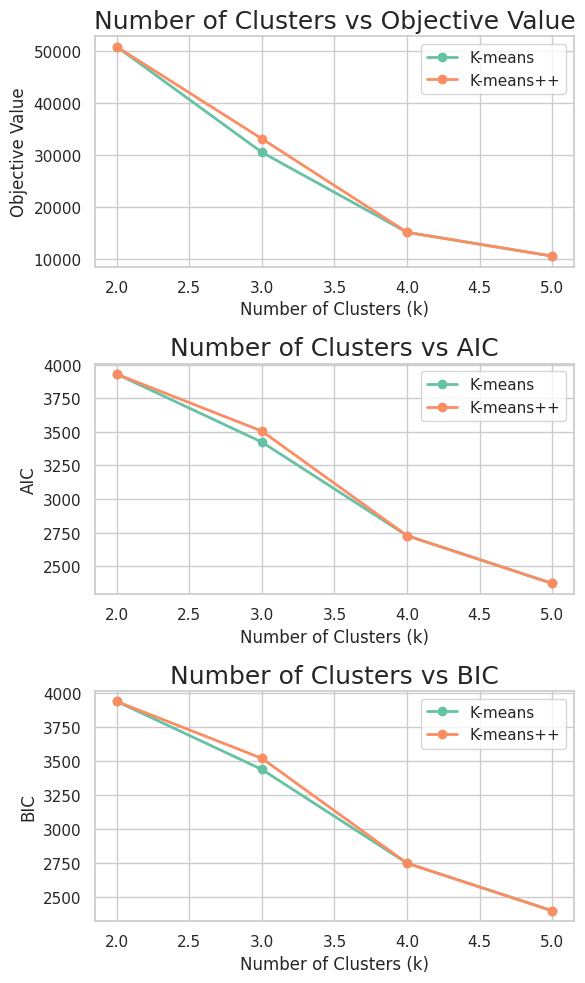

In [39]:
# Set seaborn style
sns.set(style="whitegrid")

# Create a custom color palette
colors = sns.color_palette("Set2", 2)

# Plot k vs objective, k vs AIC, and k vs BIC
plt.figure(figsize=(6, 10))

# Plot k vs Objective
plt.subplot(3, 1, 1)
plt.plot(k_values, objective_values_kmeans, marker='o', label='K-means', color=colors[0], linestyle='-', linewidth=2)
plt.plot(k_values, objective_values_kmeans_plusplus, marker='o', label='K-means++', color=colors[1], linestyle='-', linewidth=2)
plt.title('Number of Clusters vs Objective Value', fontsize=18)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Objective Value', fontsize=12)
plt.legend()

# Plot k vs AIC
plt.subplot(3, 1, 2)
plt.plot(k_values, aic_values_kmeans, marker='o', label='K-means', color=colors[0], linestyle='-', linewidth=2)
plt.plot(k_values, aic_values_kmeans_plusplus, marker='o', label='K-means++', color=colors[1], linestyle='-', linewidth=2)
plt.title('Number of Clusters vs AIC', fontsize=18)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('AIC', fontsize=12)
plt.legend()

# Plot k vs BIC
plt.subplot(3, 1, 3)
plt.plot(k_values, bic_values_kmeans, marker='o', label='K-means', color=colors[0], linestyle='-', linewidth=2)
plt.plot(k_values, bic_values_kmeans_plusplus, marker='o', label='K-means++', color=colors[1], linestyle='-', linewidth=2)
plt.title('Number of Clusters vs BIC', fontsize=18)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('BIC', fontsize=12)
plt.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig('images/problem-2/Obj-AIC-BIC.pdf')
plt.show()


3. Run the spectral clustering algorithm (spectral relaxation of K-means using Kernel-PCA) $k = 2$. Choose an appropriate kernel for this data-set and plot the clusters obtained in different colors. Explain your choice of kernel based on the output you obtain.

In [40]:
class SpectralClustering(KMeans):
    def __init__(self, k=3, kernel='rbf', degree = None, gamma=None, const_coeff=1, k_means_plusplus=False):
        super().__init__(k=k, k_means_plusplus=k_means_plusplus)
        self.degree = degree
        self.gamma = gamma
        self.const_coeff = const_coeff
        self.kernel = kernel
        self.eigenvalues = None
        self.eigenvectors = None
        self.K = None

    def _compute_kernel_matrix_(self, X, Y):
        if self.kernel == 'linear':
            return np.dot(X, Y.T)
        elif self.kernel == 'rbf':
            X_norm = np.sum(X**2, axis=1, keepdims=True)
            Y_norm = np.sum(Y**2, axis=1, keepdims=True)
            return np.exp((-1)* self.gamma * (X_norm - 2 * np.dot(X, Y.T) + Y_norm.T))
        elif self.kernel == 'poly':
            return (np.dot(X, Y.T) + self.const_coeff) ** self.degree
        else:
            raise ValueError('Unsupported kernel type.')

    def _compute_eigenvalues_and_vectors_(self, covariance_matrix):
        eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
        sorted_indices = np.argsort(eigenvalues)[::-1]
        return eigenvalues[sorted_indices], eigenvectors[:, sorted_indices]

    def _select_top_eigenvectors_(self, eigenvectors):
        return eigenvectors[:, :self.k]

    def fit(self, X):
        # Compute the kernel matrix
        self.kernel_matrix = self._compute_kernel_matrix_(X, X)

        # Compute eigenvalues and eigenvectors
        self.eigenvalues, self.eigenvectors = self._compute_eigenvalues_and_vectors_(self.kernel_matrix)

        # Form the matrix H
        H = self._select_top_eigenvectors_(self.eigenvectors)

        # Normalize each row of H to have unit length
        normalized_H = H / np.linalg.norm(H, axis=1, keepdims=True)

        # Cluster the rows of H using K-means
        self.labels, self.centroids = super().fit(normalized_H)

    def plot_clusters(self, X):
        plt.scatter(X[:, 0], X[:, 1], c=self.labels, cmap='viridis', alpha=0.5)
        plt.legend()
        if self.gamma == None:
            if self.k_means_plusplus == False:
                plt.title(f'Spectral (random): Kernel: {self.kernel}; degree: {self.degree}',fontsize=18)
                plt.savefig(f'images/problem-2/Spectral Clustering (random): Kernel: {self.kernel}; degree: {self.degree}.pdf')
            else:
                plt.title(f'Spectral (++): Kernel: {self.kernel}; degree: {self.degree}', fontsize=18)
                plt.savefig(f'images/problem-2/Spectral Clustering (++): Kernel: {self.kernel}; degree: {self.degree}.pdf')
        else:
            if self.k_means_plusplus == False:
                plt.title(f'Spectral (random): Kernel: {self.kernel}; sigma: {np.sqrt(1/(2*self.gamma))}', fontsize=18)
                plt.savefig(f'images/problem-2/Spectral Clustering (random): Kernel: {self.kernel}; sigma: {np.sqrt(1/(2*self.gamma))}.pdf')
            else:
                plt.title(f'Spectral (++): Kernel: {self.kernel}; sigma: {np.sqrt(1/(2*self.gamma))}', fontsize=18)
                plt.savefig(f'images/problem-2/Spectral Clustering (++): Kernel: {self.kernel}; sigma: {np.sqrt(1/(2*self.gamma))}.pdf')
        plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


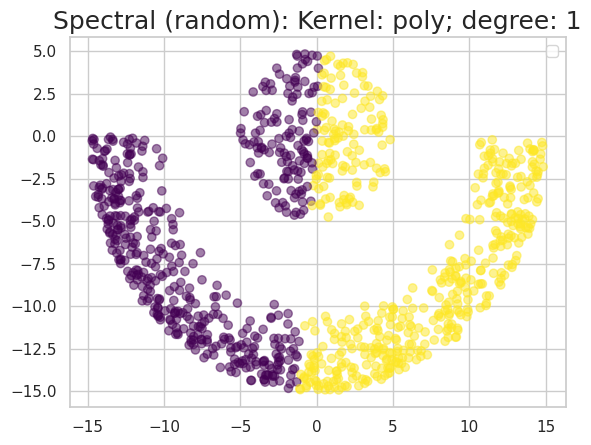

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


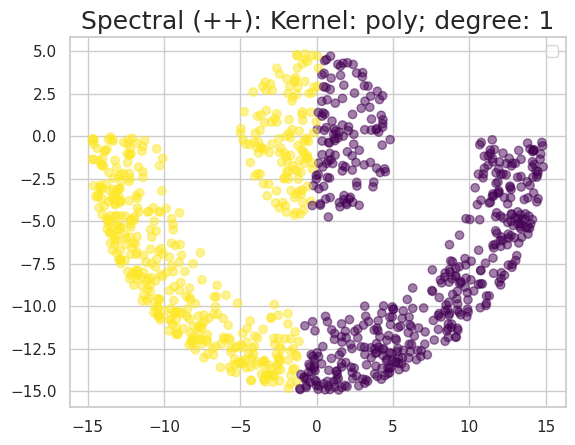

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


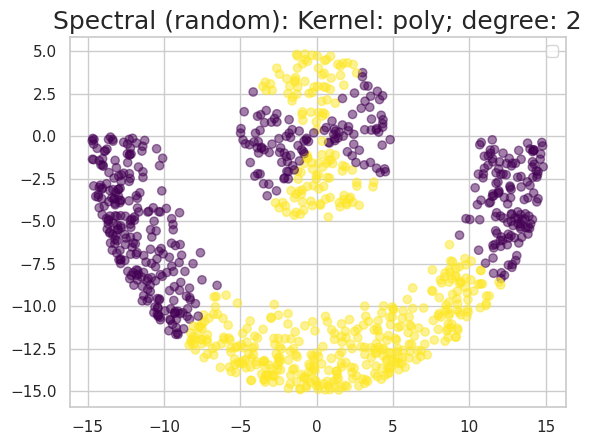

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


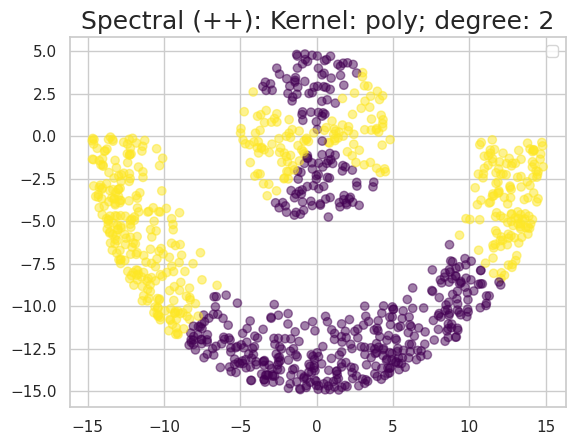

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


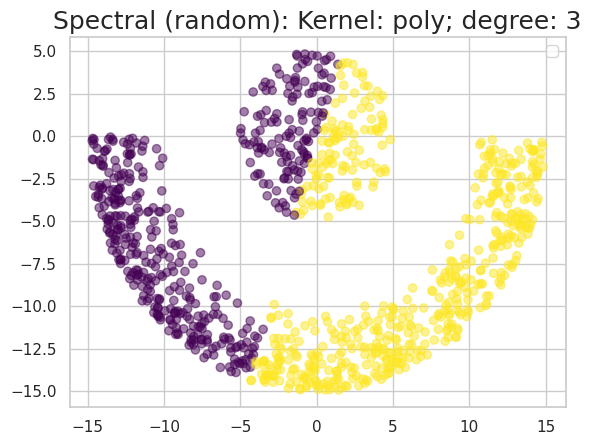

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


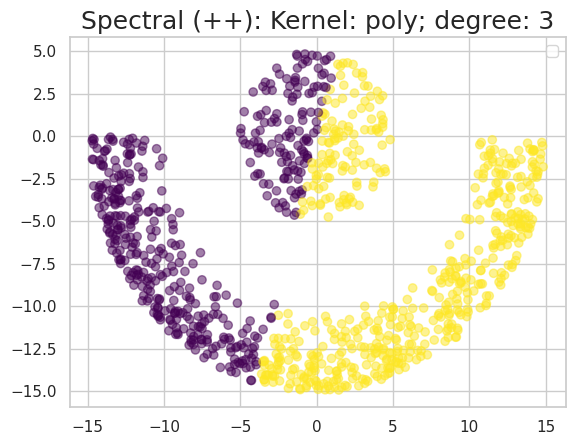

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


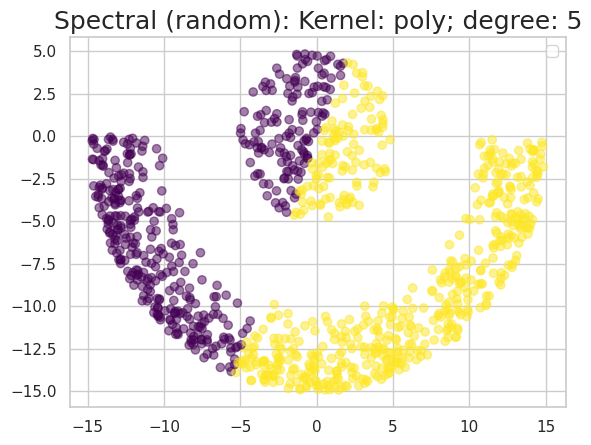

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


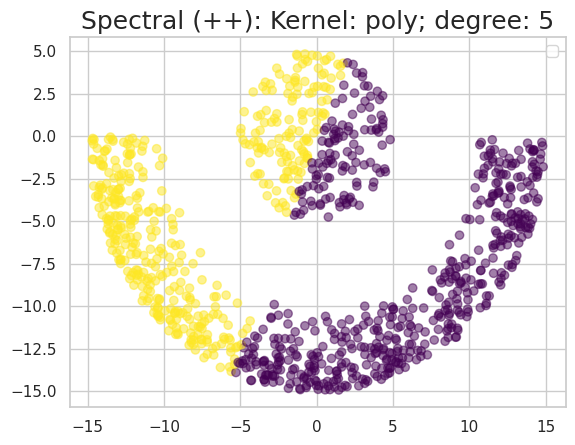

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


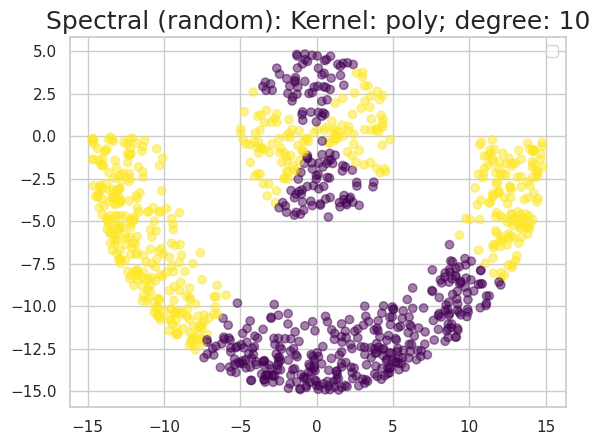

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


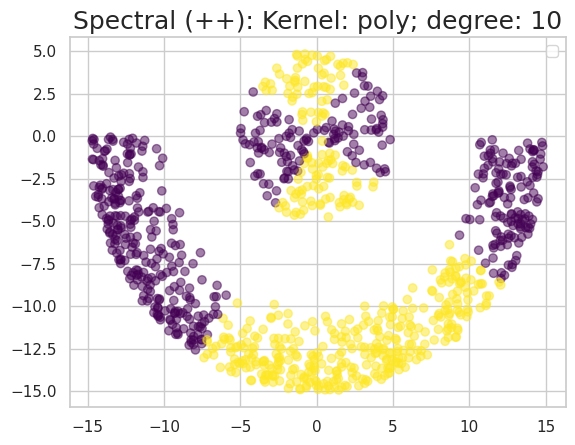

In [41]:
seed = 87
np.random.seed(seed)

# Given parameters
gamma = 1
degrees = [1, 2, 3, 5, 10]

# Set the number of clusters (k)
num_clusters = 2

for j, degree in enumerate(degrees):
    # Create SpectralClustering object with K-means random initialization
    spectral_clustering_random = SpectralClustering(
        k=num_clusters,
        kernel='poly',
        gamma=None,
        degree=degree,
        k_means_plusplus=False  # K-means with random initialization
    )

    # Fit the data using Spectral Clustering with K-means random initialization
    spectral_clustering_random.fit(dataset)

    # Plot the results for Spectral Clustering with K-means random initialization
    spectral_clustering_random.plot_clusters(dataset)

    # Create SpectralClustering object with K-means++ initialization
    spectral_clustering_kmeans_pp = SpectralClustering(
        k=num_clusters,
        kernel='poly',
        gamma=None,
        degree=degree,
        k_means_plusplus=True  # K-means++ initialization
    )

    # Fit the data using Spectral Clustering with K-means++ initialization
    spectral_clustering_kmeans_pp.fit(dataset)

    # Plot the results for Spectral Clustering with K-means++ initialization
    spectral_clustering_kmeans_pp.plot_clusters(dataset)


<ipython-input-40-a4ae2f96e1be>:43: RuntimeWarning: invalid value encountered in divide
  normalized_H = H / np.linalg.norm(H, axis=1, keepdims=True)
<ipython-input-35-75ad031cbac5>:28: RuntimeWarning: Mean of empty slice.
  new_centroids = np.array([X[self.labels == j].mean(axis=0) for j in range(self.k)])
/home/janmenjaya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


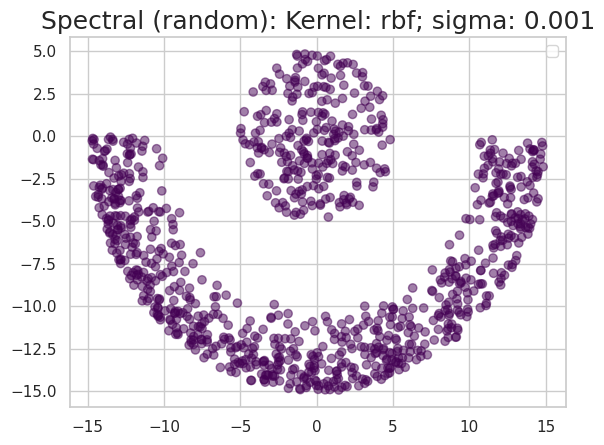

<ipython-input-40-a4ae2f96e1be>:43: RuntimeWarning: invalid value encountered in divide
  normalized_H = H / np.linalg.norm(H, axis=1, keepdims=True)
<ipython-input-35-75ad031cbac5>:28: RuntimeWarning: Mean of empty slice.
  new_centroids = np.array([X[self.labels == j].mean(axis=0) for j in range(self.k)])
/home/janmenjaya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


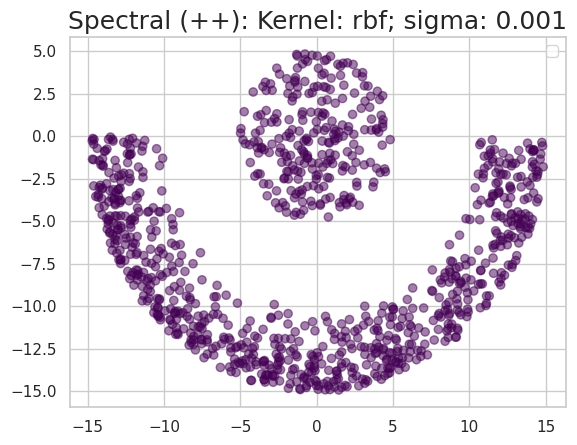

<ipython-input-40-a4ae2f96e1be>:43: RuntimeWarning: invalid value encountered in divide
  normalized_H = H / np.linalg.norm(H, axis=1, keepdims=True)
<ipython-input-35-75ad031cbac5>:28: RuntimeWarning: Mean of empty slice.
  new_centroids = np.array([X[self.labels == j].mean(axis=0) for j in range(self.k)])
/home/janmenjaya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


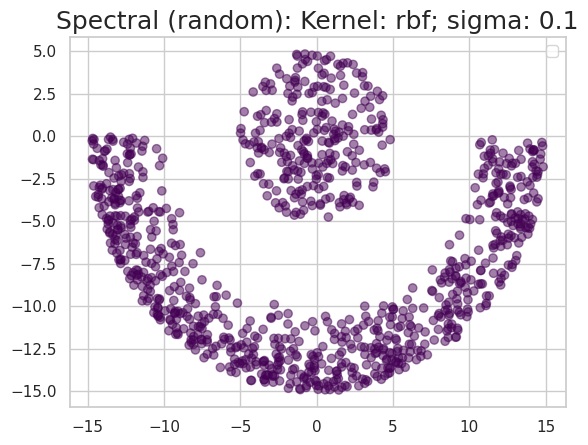

<ipython-input-40-a4ae2f96e1be>:43: RuntimeWarning: invalid value encountered in divide
  normalized_H = H / np.linalg.norm(H, axis=1, keepdims=True)
<ipython-input-35-75ad031cbac5>:28: RuntimeWarning: Mean of empty slice.
  new_centroids = np.array([X[self.labels == j].mean(axis=0) for j in range(self.k)])
/home/janmenjaya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


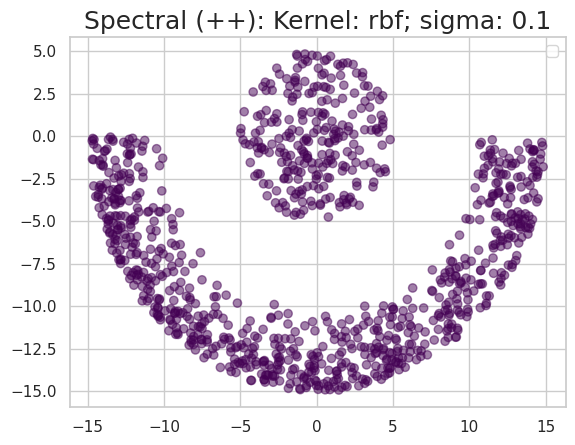

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


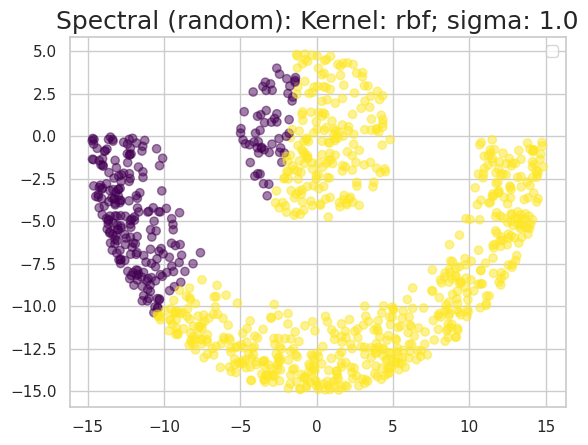

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


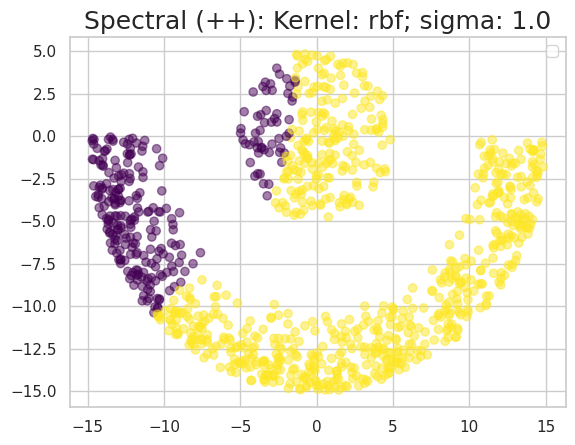

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


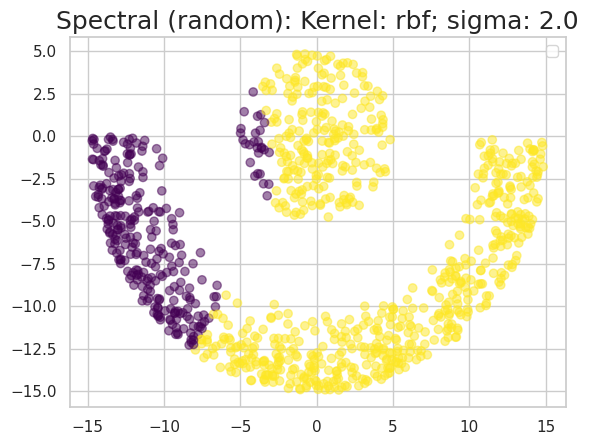

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


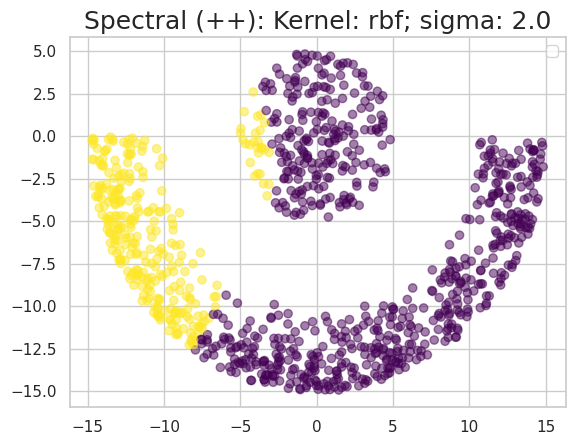

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


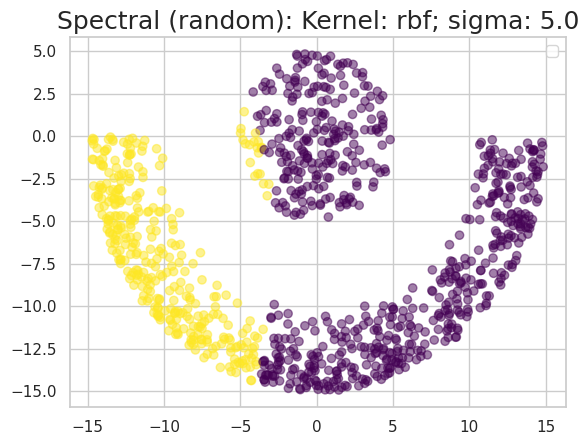

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


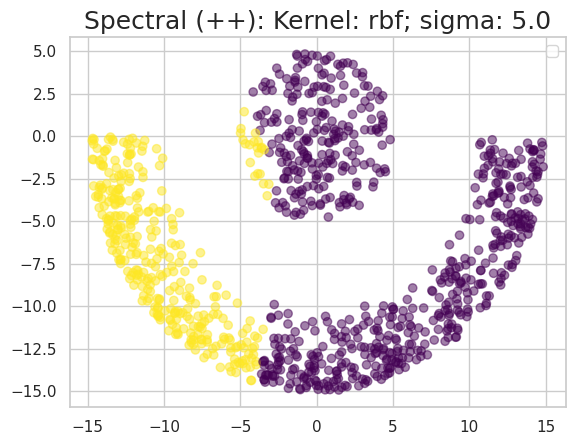

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


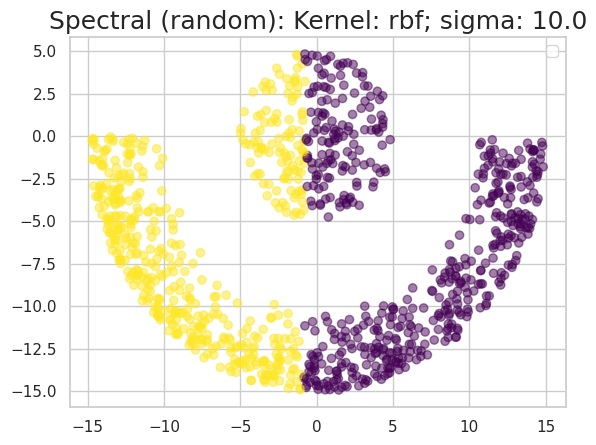

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


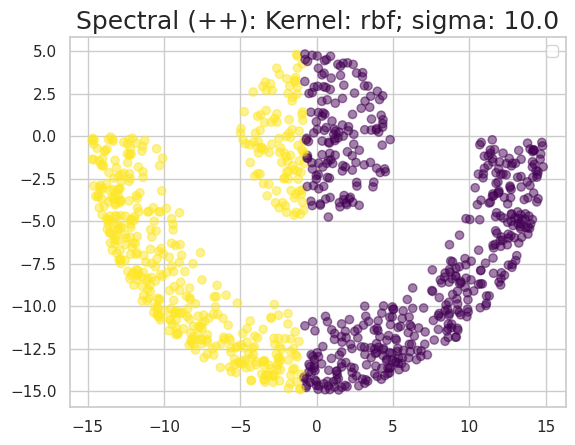

In [42]:
seed = 87
np.random.seed(seed)

# Given parameters
sigmas = np.array([0.001, 0.1, 1, 2, 5, 10])
gammas = 1 / (2 * sigmas **2)

# Set the number of clusters (k)
num_clusters = 2

for j, gamma in enumerate(gammas):
    # Create SpectralClustering object with K-means random initialization
    spectral_clustering_random = SpectralClustering(
        k=num_clusters,
        kernel='rbf',
        gamma=gamma,
        degree=None,
        k_means_plusplus=False  # K-means with random initialization
    )

    # Fit the data using Spectral Clustering with K-means random initialization
    spectral_clustering_random.fit(dataset)

    # Plot the results for Spectral Clustering with K-means random initialization
    spectral_clustering_random.plot_clusters(dataset)

    # Create SpectralClustering object with K-means++ initialization
    spectral_clustering_kmeans_pp = SpectralClustering(
        k=num_clusters,
        kernel='rbf',
        gamma=gamma,
        degree=None,
        k_means_plusplus=True  # K-means++ initialization
    )

    # Fit the data using Spectral Clustering with K-means++ initialization
    spectral_clustering_kmeans_pp.fit(dataset)

    # Plot the results for Spectral Clustering with K-means++ initialization
    spectral_clustering_kmeans_pp.plot_clusters(dataset)